In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

# Momentum Trading Strategy

## Download Data

In [2]:
import os

cwd = os.getcwd()
# Check if price data have been saved
price_data = os.path.join(cwd, "price_data")
if not os.path.exists(price_data):
    # Getting the Nasdaq 100 ticker symbols from Wikipedia
    nas_df = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100")[4]
    tickers = nas_df.Ticker.to_list()
    # Download the Nasdaq 100 Adjusted Close price data with yfinance
    df = yf.download(tickers, start="2010-01-01")
    # Create price_data directory
    os.makedirs(price_data)
    # Save a copy of the dataframe to price_data directory
    df.to_csv(os.path.join(price_data, "Nasdaq-100.csv"))
else:
    # Load the Nasdaq-100.csv
    df = pd.read_csv(os.path.join(price_data, "Nasdaq-100.csv"), 
                     header=[0,1], index_col=0)
    df.index = pd.to_datetime(df.index)

## Strategy

In [3]:
def get_top(df, periods, top_picks, r=.2):
    # Check if periods and top_picks has the same length
    assert len(periods) == len(top_picks), \
        "Length of periods and length of top_picks is not the same"
    # Initializing all availible symbols from dataframe columns
    symbols = df.columns.to_list()
    # Looping through both periods and top_picks to pick out
    # the top performance tickers
    for p, t in zip(periods, top_picks):
        # Calculate the cumulative product of the given period
        # also droping any columns containing NaN value
        sym = df[symbols].dropna(axis=1).iloc[-p:]
        ret = sym.prod()
        # Picking the top N ticker symbols for the next round
        symbols = ret.nlargest(t).index.to_list()
    # return the top performance tickers symbols
    return symbols

In [4]:
def cal_returns(
    df,
    base_df=None,
    periods=[12, 6, 3],
    top_picks=[50, 30, 10]):
    
    if base_df is None:
        base_df = df.copy()

    max_p = max(periods) + 1
    returns = []
    picks = []

    for i in range(max_p, len(df)):
        s, e = i - max_p, i - 1
        # Getting top 10 ticker symbol
        topk_tickers = get_top(base_df.iloc[s:e], periods, top_picks)
        # Getting the portfolio performance
        pf = np.mean(df[topk_tickers].iloc[i])
        # Appending datas
        returns.append(pf)
        picks += topk_tickers
    
    return dict(
        picks=pd.Series(picks).value_counts(),
        returns=pd.Series(returns, index=df.index[max_p:]))

In [5]:
def plot_results(results):
    # Plotting the Return curve
    picks_df = results['picks']
    ret_df = results['returns']
    print(f"Current cumulative return: {ret_df.prod():.2f}")
    print("Top 5 picks:")
    print(picks_df.head(5))
    ret_df.cumprod().plot()

## Percent Change Calculation

In [90]:
freq = 'M'
close = df['Close'].groupby(by=pd.Grouper(freq=freq)).last()
high = df['High'].groupby(by=pd.Grouper(freq=freq)).max()
low = df['Low'].groupby(by=pd.Grouper(freq=freq)).min()
base = close.shift(1)

ret_m = (close / base).iloc[1:]
ret_l = (low / base).iloc[1:]
ret_h = (high / low.shift(1)).iloc[1:]

### Base

In [95]:
results = cal_returns(ret_m, 
                      top_picks=[50, 25, 3])

Current cumulative return: 71.01
Top 5 picks:
ENPH    28
TSLA    22
NVDA    19
REGN    15
SGEN    15
dtype: int64


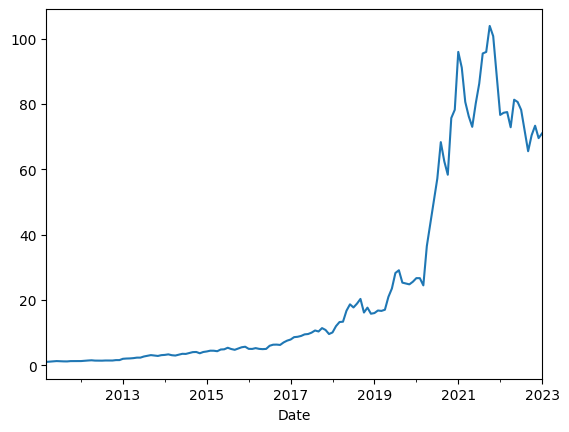

In [96]:
plot_results(results)

### Risky

In [91]:
results = cal_returns(ret_m, ret_h,
                      top_picks=[50, 25, 3])

Current cumulative return: 166.67
Top 5 picks:
ENPH    80
AMD     36
TSLA    32
NFLX    20
MRNA    18
dtype: int64


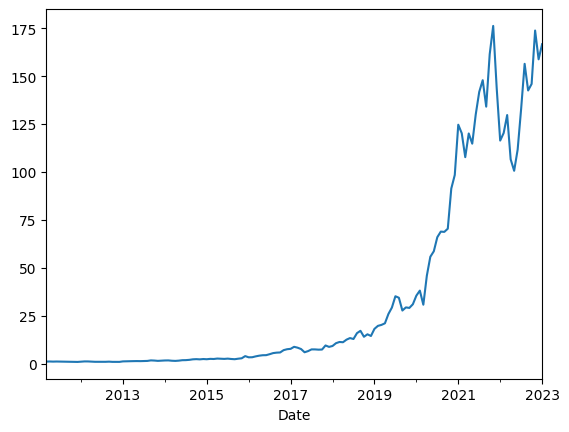

In [92]:
plot_results(results)

### Safe (low risk)

In [93]:
results = cal_returns(ret_m, ret_l, 
                      top_picks=[50, 25, 12])

Current cumulative return: 7.69
Top 5 picks:
PEP     80
COST    56
PAYX    54
KDP     54
XEL     51
dtype: int64


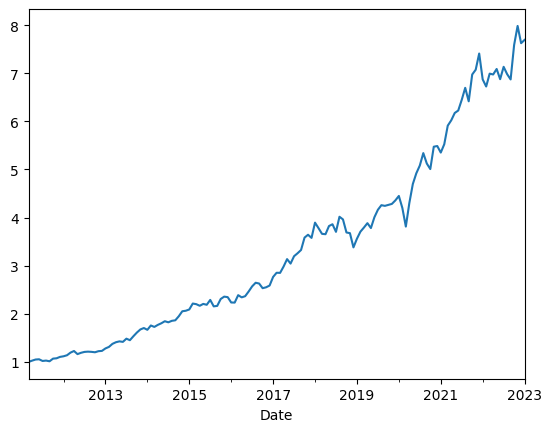

In [94]:
plot_results(results)